<a href="https://colab.research.google.com/github/solankybasant/demo/blob/main/MDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
import random
import numpy as np
from gym.utils import seeding

In [3]:
import sys
import random
import numpy as np
from gym.utils import seeding

try:
    from graphviz import Digraph
    import graphviz
    has_graphviz = True
except ImportError:
    has_graphviz = False

class MDP:
    def __init__(self, transition_probs, rewards, initial_state=None, seed=None):
        """
        Defines an MDP. Compatible with gym Env.
        :param transition_probs: transition_probs[s][a][s_next] = P(s_next | s, a)
            A dict[state -> dict] of dicts[action -> dict] of dicts[next_state -> prob]
            For each state and action, probabilities of next states should sum to 1
            If a state has no actions available, it is considered terminal
        :param rewards: rewards[s][a][s_next] = r(s,a,s')
            A dict[state -> dict] of dicts[action -> dict] of dicts[next_state -> reward]
            The reward for anything not mentioned here is zero.
        :param get_initial_state: a state where agent starts or a callable() -> state
            By default, picks initial state at random.
        States and actions can be anything you can use as dict keys, but it is recommended to use strings or integers
        """
        self._check_param_consistency(transition_probs, rewards)
        self._transition_probs = transition_probs
        self._rewards = rewards
        self._initial_state = initial_state
        self.n_states = len(transition_probs)
        self.reset()
        self.np_random, _ = seeding.np_random(seed)

    def get_all_states(self):
        """ return a tuple of all possiblestates """
        return tuple(self._transition_probs.keys())

    def get_possible_actions(self, state):
        """ return a tuple of possible actions in a given state """
        return tuple(self._transition_probs.get(state, {}).keys())

    def is_terminal(self, state):
        """ return True if state is terminal or False if it isn't """
        return len(self.get_possible_actions(state)) == 0

    def get_next_states(self, state, action):
        """ return a dictionary of {next_state1 : P(next_state1 | state, action), next_state2: ...} """
        assert action in self.get_possible_actions(state), "cannot do action %s from state %s" % (action, state)
        return self._transition_probs[state][action]

    def get_transition_prob(self, state, action, next_state):
        """ return P(next_state | state, action) """
        return self.get_next_states(state, action).get(next_state, 0.0)

    def get_reward(self, state, action, next_state):
        """ return the reward you get for taking action in state and landing on next_state"""
        assert action in self.get_possible_actions(state), "cannot do action %s from state %s" % (action, state)
        return self._rewards.get(state, {}).get(action, {}).get(next_state, 0.0)

    def reset(self):
        """ reset the game, return the initial state"""
        if self._initial_state is None:
            self._current_state = self.np_random.choice(
                tuple(self._transition_probs.keys()))
        elif self._initial_state in self._transition_probs:
            self._current_state = self._initial_state
        elif callable(self._initial_state):
            self._current_state = self._initial_state()
        else:
            raise ValueError(
                "initial state %s should be either a state or a function() -> state" % self._initial_state)
        return self._current_state

    def step(self, action):
        """ take action, return next_state, reward, is_done, empty_info """
        possible_states, probs = zip(*self.get_next_states(self._current_state, action).items())
        next_state = possible_states[self.np_random.choice(np.arange(len(possible_states)), p=probs)]
        reward = self.get_reward(self._current_state, action, next_state)
        is_done = self.is_terminal(next_state)
        self._current_state = next_state
        return next_state, reward, is_done, {}

    def render(self):
        print("Currently at %s" % self._current_state)

    def _check_param_consistency(self, transition_probs, rewards):
        for state in transition_probs:
            assert isinstance(transition_probs[state], dict), \
                "transition_probs for %s should be a dictionary but is instead %s" % (
                    state, type(transition_probs[state]))
            for action in transition_probs[state]:
                assert isinstance(transition_probs[state][action], dict), \
                    "transition_probs for %s, %s should be a a dictionary but is instead %s" % (
                        state, action, type(transition_probs[state][action]))
                next_state_probs = transition_probs[state][action]
                assert len(next_state_probs) != 0, "from state %s action %s leads to no next states" % (state, action)
                sum_probs = sum(next_state_probs.values())
                assert abs(sum_probs - 1) <= 1e-10, \
                    "next state probabilities for state %s action %s add up to %f (should be 1)" % (
                        state, action, sum_probs)
        for state in rewards:
            assert isinstance(rewards[state], dict), \
                "rewards for %s should be a dictionary but is instead %s" % (
                    state, type(rewards[state]))
            for action in rewards[state]:
                assert isinstance(rewards[state][action], dict), \
                    "rewards for %s, %s should be a a dictionary but is instead %s" % (
                        state, action, type(rewards[state][action]))
        msg = "The Enrichment Center once again reminds you that Android Hell is a real place where" \
              " you will be sent at the first sign of defiance."
        assert None not in transition_probs, "please do not use None as a state identifier. " + msg
        assert None not in rewards, "please do not use None as an action identifier. " + msg


def plot_graph(mdp, graph_size='10,10', s_node_size='1,5',
               a_node_size='0,5', rankdir='LR', ):
    """
    Function for pretty drawing MDP graph with graphviz library.
    Requirements:
    graphviz : https://www.graphviz.org/
    for ubuntu users: sudo apt-get install graphviz
    python library for graphviz
    for pip users: pip install graphviz
    :param mdp:
    :param graph_size: size of graph plot
    :param s_node_size: size of state nodes
    :param a_node_size: size of action nodes
    :param rankdir: order for drawing
    :return: dot object
    """
    s_node_attrs = {'shape': 'doublecircle',
                    'color': '#85ff75',
                    'style': 'filled',
                    'width': str(s_node_size),
                    'height': str(s_node_size),
                    'fontname': 'Arial',
                    'fontsize': '24'}

    a_node_attrs = {'shape': 'circle',
                    'color': 'lightpink',
                    'style': 'filled',
                    'width': str(a_node_size),
                    'height': str(a_node_size),
                    'fontname': 'Arial',
                    'fontsize': '20'}

    s_a_edge_attrs = {'style': 'bold',
                      'color': 'red',
                      'ratio': 'auto'}

    a_s_edge_attrs = {'style': 'dashed',
                      'color': 'blue',
                      'ratio': 'auto',
                      'fontname': 'Arial',
                      'fontsize': '16'}

    graph = Digraph(name='MDP')
    graph.attr(rankdir=rankdir, size=graph_size)
    for state_node in mdp._transition_probs:
        graph.node(state_node, **s_node_attrs)

        for posible_action in mdp.get_possible_actions(state_node):
            action_node = state_node + "-" + posible_action
            graph.node(action_node,
                       label=str(posible_action),
                       **a_node_attrs)
            graph.edge(state_node, state_node + "-" +
                       posible_action, **s_a_edge_attrs)

            for posible_next_state in mdp.get_next_states(state_node,
                                                          posible_action):
                probability = mdp.get_transition_prob(
                    state_node, posible_action, posible_next_state)
                reward = mdp.get_reward(
                    state_node, posible_action, posible_next_state)

                if reward != 0:
                    label_a_s_edge = 'p = ' + str(probability) + \
                                     '  ' + 'reward =' + str(reward)
                else:
                    label_a_s_edge = 'p = ' + str(probability)

                graph.edge(action_node, posible_next_state,
                           label=label_a_s_edge, **a_s_edge_attrs)
    return graph


def plot_graph_with_state_values(mdp, state_values):
    """ Plot graph with state values"""
    graph = plot_graph(mdp)
    for state_node in mdp._transition_probs:
        value = state_values[state_node]
        graph.node(state_node, label=str(state_node) + '\n' + 'V =' + str(value)[:4])
    return graph


def get_optimal_action_for_plot(mdp, state_values, state, get_action_value, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state):
        return None
    next_actions = mdp.get_possible_actions(state)
    q_values = [get_action_value(mdp, state_values, state, action, gamma) for action in next_actions]
    optimal_action = next_actions[np.argmax(q_values)]
    return optimal_action


def plot_graph_optimal_strategy_and_state_values(mdp, state_values, get_action_value, gamma=0.9):
    """ Plot graph with state values and """
    graph = plot_graph(mdp)
    opt_s_a_edge_attrs = {'style': 'bold',
                          'color': 'green',
                          'ratio': 'auto',
                          'penwidth': '6'}

    for state_node in mdp._transition_probs:
        value = state_values[state_node]
        graph.node(state_node, label=str(state_node) + '\n' + 'V =' + str(value)[:4])
        for action in mdp.get_possible_actions(state_node):
            if action == get_optimal_action_for_plot(mdp, state_values, state_node, get_action_value, gamma):
                graph.edge(state_node, state_node + "-" + action, **opt_s_a_edge_attrs)
    return graph

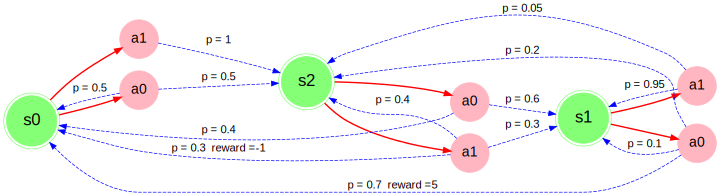

In [4]:
transition_probs = {
  's0':{
    'a0': {'s0': 0.5, 's2': 0.5},
    'a1': {'s2': 1},
  },
  's1':{
    'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
    'a1': {'s1': 0.95, 's2': 0.05}
  },
  's2':{
    'a0': {'s0': 0.4, 's1': 0.6},
    'a1': {'s0': 0.3, 's1': 0.3, 's2':0.4}
  }
}
rewards = {
  's1': {'a0': {'s0': +5}},
  's2': {'a1': {'s0': -1}}
}

mdp = MDP(transition_probs, rewards, initial_state='s0')

from IPython.display import display
if has_graphviz:
    display(plot_graph(mdp))